# Plot Ground Truth

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from copy import deepcopy
from typing import Tuple
import matplotlib.patches as patches
import os
import random

# Define the transformation functions
def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int) -> Tuple[int, int]:
    """
    Compute the output size given input size and target long side length.
    """
    scale = long_side_length * 1.0 / max(oldh, oldw)
    newh, neww = oldh * scale, oldw * scale
    neww = int(neww + 0.5)
    newh = int(newh + 0.5)
    return (newh, neww)

def inverse_coords(coords: np.ndarray, original_size: Tuple[int, int], target_length=1024) -> np.ndarray:
    """
    Inverse transformation of coordinates from resized back to original.
    """
    old_h, old_w = original_size
    new_h, new_w = get_preprocess_shape(old_h, old_w, target_length)
    coords = deepcopy(coords).astype(float)
    coords[..., 0] = coords[..., 0] * (old_w / new_w)
    coords[..., 1] = coords[..., 1] * (old_h / new_h)
    return coords

def inverse_boxes(boxes: np.ndarray, original_size: Tuple[int, int], target_length=1024) -> np.ndarray:
    """
    Inverse transformation of boxes from resized back to original.
    """
    boxes = inverse_coords(boxes.reshape(-1, 2, 2), original_size, target_length)
    return boxes.reshape(-1, 4)

def convert_boxes(boxes):
    # Convert the boxes from center format to [y_min, x_min, y_max, x_max] format
    converted_boxes = np.zeros_like(boxes)
    converted_boxes[:, 0] = boxes[:, 1] - boxes[:, 3] / 2.0  # x_min
    converted_boxes[:, 1] = boxes[:, 0] - boxes[:, 2] / 2.0  # y_min
    converted_boxes[:, 2] = boxes[:, 1] + boxes[:, 3] / 2.0  # x_max
    converted_boxes[:, 3] = boxes[:, 0] + boxes[:, 2] / 2.0  # y_max
    return converted_boxes

def plot_bbox(image, original_boxes, title, bbox_color='r'):
    """
    Plot the image with bounding boxes.
    
    Parameters:
    - image: The image to be displayed.
    - original_boxes: A list of bounding boxes, where each bounding box is defined by (x_min, y_min, x_max, y_max).
    - title: The title of the plot.
    - bbox_color: The color of the bounding boxes. Default is red ('r').
    """
    #plt.figure(figsize=(6, 6))
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()

    for box in original_boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=bbox_color, facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.title(title)
    plt.show()

def plot_bbox_with_confidence_score(image, original_boxes, confidence_scores, title, bbox_color='r', show_confidence_score=True, save_path=None):
    """
    Plot the image with bounding boxes and confidence scores for each box.
    
    Parameters:
    - image: The image to be displayed.
    - original_boxes: A list of bounding boxes, where each bounding box is defined by (x_min, y_min, x_max, y_max).
    - confidence_scores: A list of confidence scores corresponding to each bounding box.
    - title: The title of the plot.
    - bbox_color: The color of the bounding boxes. Default is red ('r').
    """
    #plt.figure(figsize=(6, 6))
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()

    for box, score in zip(original_boxes, confidence_scores):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=bbox_color, facecolor='none')
        ax.add_patch(rect)
        if show_confidence_score:
            ax.text(x_min, y_min, '{:.2f}'.format(score), bbox=dict(facecolor='white', alpha=0.5))

    plt.axis('off')
    plt.title(title)
    if save_path:
        plt.savefig(save_path)
    plt.show()


# Load SAM model and generate image embdding

In [2]:
cd /home/icb/hanyi.zhang/Detection_Head/segment-anything

/ictstr01/home/icb/hanyi.zhang/Detection_Head/segment-anything


/home/icb/hanyi.zhang/.local/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.separate_sam_encoder import SamEncoder
import torch

sam_checkpoint = "/home/icb/hanyi.zhang/Detection_Head/segment-anything/sam_vit_l_0b3195.pth"
model_type = "vit_l"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

sam_image_encoder = SamEncoder(sam, device)
predictor = SamPredictor(sam)


# Load the Model Checkpoint and evaluate

In [4]:
cd /home/icb/hanyi.zhang/Detection_Head

/ictstr01/home/icb/hanyi.zhang/Detection_Head


/home/icb/hanyi.zhang/.local/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
# Load checkpoint here
import torch
from detection_head_model import DetectionHead

#checkpoint_path = '/home/icb/hanyi.zhang/Detection_Head/checkpoints/DetectionHead_training-original-epoch=299-val_loss=7.69.ckpt' 
#checkpoint_path = '/home/icb/hanyi.zhang/Detection_Head/checkpoints/DetectionHead_training-smaller-patches-epoch=299-val_loss=9.22.ckpt'
checkpoint_path = '/home/icb/hanyi.zhang/Detection_Head/checkpoints/DetectionHead_training-aug-epoch=299-val_loss=6.30.ckpt'
model = DetectionHead.load_from_checkpoint(checkpoint_path)

# Set the model to evaluation mode
model.eval()

# Determine device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DetectionHead(
  (matcher): HungarianMatcher()
  (criterion): SetCriterion(
    (matcher): HungarianMatcher()
  )
  (query_embed): Embedding(100, 256)
  (position_embedding): PositionEmbeddingSine()
  (transformer_decoder): TransformerDecoder(
    (self_attention_layers): ModuleList(
      (0-5): 6 x SelfAttentionLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (cross_attention_layers): ModuleList(
      (0-5): 6 x CrossAttentionLayer(
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (ffn_layers): ModuleL

In [6]:
import os
import numpy as np
from PIL import Image
from sklearn.metrics import precision_recall_curve, average_precision_score
from scipy.optimize import linear_sum_assignment
import json

# Function to load checkpoint and perform evaluation on one example
def evaluate_single_example(model, img_emb, threshold=0.5):
    # Prepare the input
    img_emb = torch.tensor(img_emb, dtype=torch.float32).to(device)  # Convert and move to GPU if available
    
    # Dummy query embedding (you may adjust this based on your actual implementation)
    query_embed = model.query_embed.weight.to(device)
    
    # Get positional embedding
    pos_embedding = model.position_embedding(img_emb)
    
    # Forward pass
    with torch.no_grad():
        outputs = model(query_embedding=query_embed, image_embedding=img_emb, pos_embedding=pos_embedding)

    # Apply softmax to pred_logits
    pred_logits = torch.nn.functional.softmax(outputs['pred_logits'][0], dim=-1)
    
    # Convert softmax output to binary predictions (0 or 1)
    # If probability of class 0 is larger than the threshold, it is considered as an object
    binary_predictions = (pred_logits[:, 0] > threshold).cpu().numpy().astype(int)
    
    # Filter out boxes with binary prediction value 0
    pred_boxes = outputs['pred_boxes'].cpu().numpy()[0]
    filtered_boxes = pred_boxes[binary_predictions == 1]
    confidence_scores = pred_logits[binary_predictions == 1, 0].cpu().numpy()
    
    return filtered_boxes, confidence_scores

def non_max_suppression(bboxes, scores, threshold):
    """Perform Non-Maximum Suppression (NMS) on bounding boxes.
    
    Args:
    bboxes (numpy.ndarray): Array of bounding boxes in the format (x1, y1, x2, y2).
    scores (numpy.ndarray): Array of scores for each bounding box.
    threshold (float): IoU threshold for suppression.

    Returns:
    numpy.ndarray: Array of indices of bounding boxes to keep.
    """
    # Sort the bounding boxes by the scores in descending order
    indices = np.argsort(scores)[::-1]
    
    keep = []
    while len(indices) > 0:
        current = indices[0]
        keep.append(current)
        
        if len(indices) == 1:
            break
        
        current_box = bboxes[current]
        remaining_boxes = bboxes[indices[1:]]
        
        # Compute IoU of the current box with the rest
        ious = np.array([compute_iou(current_box, box) for box in remaining_boxes])
        
        # Select boxes with IoU less than the threshold
        indices = indices[1:][ious < threshold]
    
    return np.array(keep)

def compute_iou(box1, box2):
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])

    intersection_area = max(0, x2_min - x1_max) * max(0, y2_min - y1_max)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - intersection_area

    if union_area == 0:
        return 0.0

    iou = intersection_area / union_area
    return iou

# Use Hungarian Matching
def evaluate_detections(gt_boxes, pred_boxes, confidence_scores, iou_threshold=0.5):
    num_gt = len(gt_boxes)
    num_pred = len(pred_boxes)
    
    iou_matrix = np.zeros((num_gt, num_pred))
    
    for i, gt_box in enumerate(gt_boxes):
        for j, pred_box in enumerate(pred_boxes):
            iou_matrix[i, j] = compute_iou(gt_box, pred_box)
    
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)
    
    matches = [(i, j) for i, j in zip(row_ind, col_ind) if iou_matrix[i, j] >= iou_threshold]
    
    matched_gt_indices = {gt_idx for gt_idx, _ in matches}
    matched_pred_indices = {pred_idx for _, pred_idx in matches}

    true_positives = len(matched_gt_indices)
    false_positives = len(pred_boxes) - len(matched_pred_indices)
    false_negatives = len(gt_boxes) - len(matched_gt_indices)
    
    iou_sum = sum(iou_matrix[gt_idx, pred_idx] for gt_idx, pred_idx in matches)
    average_iou = iou_sum / len(matches) if matches else 0
    
    if len(pred_boxes) != 0:
        y_true = [1 if i in matched_pred_indices else 0 for i in range(len(pred_boxes))]
        ap = average_precision_score(y_true, confidence_scores)
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    else:
        ap = 0
        precision = 0
    
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return {
        'average_iou': average_iou,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'ap': ap,
        'precision': precision,
        'recall': recall
    }


# Images from Neurips Dataset

Threshold for confidence scores: 0.5
Average IOU      : 0.78
Precision        : 0.68
Recall           : 0.85
True Positives   : 63
False Positives  : 29
False Negatives  : 11


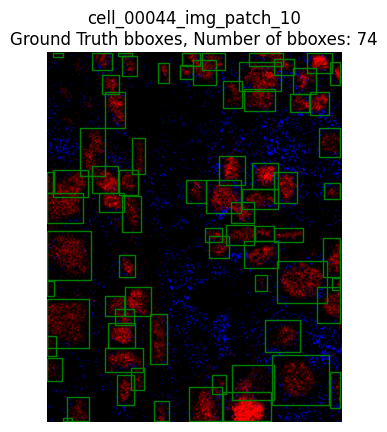

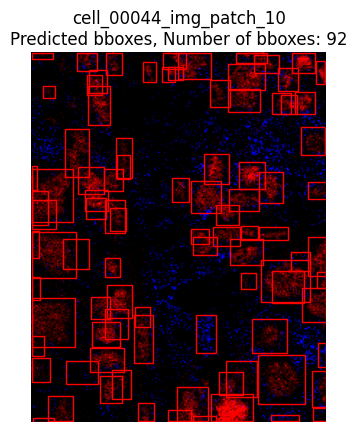

In [89]:
# Define paths
#img_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/train/images_patches/'
#img_emb_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/train/images_patches_emb/'
#label_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/train/targets/'
#mask_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/train/mask_patches'

#img_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/test/images_patches/'
#img_emb_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/test/images_patches_emb/'
#label_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/test/targets/'
#mask_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/test/mask_patches'
base_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png-small/test'
img_folder = os.path.join(base_folder, 'images_patches')
img_emb_folder = os.path.join(base_folder, 'images_patches_emb')
label_folder = os.path.join(base_folder, 'targets')
mask_folder = os.path.join(base_folder, 'labels_patches')

# Define NMS threshold
threshold = 0.5

# Get list of files
img_emb_files = sorted(os.listdir(img_emb_folder))

# Index for image
idx = np.random.randint(0, len(img_emb_files))
img_emb_file = img_emb_files[idx]
file_idx = img_emb_file.rsplit('.', 1)[0]

# Define image path, label path and image embedding path
image_path = os.path.join(img_folder, file_idx + '.png')
labels_path = os.path.join(label_folder, file_idx.replace('_img_', '_label_') + '.npy')
image_embedding_path = os.path.join(img_emb_folder, img_emb_file)

# Read Ground Truth bounding boxes
ground_truth_boxes = np.load(labels_path)

# Read the image
image = Image.open(image_path)

# Get the original size of the image
original_size = image.size  # (width, height)
original_size = (original_size[1], original_size[0])  # Convert to (height, width)
original_boxes_gt = inverse_boxes(convert_boxes(ground_truth_boxes) * 1024, original_size)

# Load image embedding
image_embedding = np.load(image_embedding_path)

#for th in [0.5, 0.8]:
th=0.5
print('Threshold for confidence scores: ' + str(th))
# Predict boxes and convert to original size
predicted_boxes, confidence_scores = evaluate_single_example(model, image_embedding, threshold=th)
original_boxes_pred = inverse_boxes(convert_boxes(predicted_boxes) * 1024, original_size)

kept_indices = non_max_suppression(original_boxes_pred, confidence_scores, threshold)
if len(kept_indices) != 0:
    original_boxes_pred_filtered = original_boxes_pred[kept_indices]
    filtered_confidences = confidence_scores[kept_indices]
else:
    original_boxes_pred_filtered = []
    filtered_confidences = []

results = evaluate_detections(original_boxes_gt, original_boxes_pred_filtered, filtered_confidences, iou_threshold=0.5)

print(f"Average IOU      : {results['average_iou']:.2f}")
print(f"Precision        : {results['precision']:.2f}")
print(f"Recall           : {results['recall']:.2f}")
print(f"True Positives   : {results['true_positives']}")
print(f"False Positives  : {results['false_positives']}")
print(f"False Negatives  : {results['false_negatives']}")
#print(f"Average Precision: {results['ap']:.2f}")


title1 = file_idx + '\n' + 'Ground Truth bboxes, ' + 'Number of bboxes: ' + str(len(original_boxes_gt))
title2 = file_idx + '\n' + 'Predicted bboxes, ' + 'Number of bboxes: ' + str(len(original_boxes_pred_filtered))
plot_bbox(image, original_boxes_gt, title1, bbox_color='g')
plot_bbox_with_confidence_score(image, original_boxes_pred_filtered, filtered_confidences, title2, bbox_color='r', show_confidence_score=False)

# Feed bboxes to SAM as prompt

In [70]:
def show_mask(mask, ax, random_color=False, title=None):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    if title:
        ax.set_title(title)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [71]:
import cv2
image = cv2.imread(image_path)
predictor.set_image(image)

input_boxes = torch.tensor(original_boxes_pred_filtered).to(device)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [72]:
mask_path = os.path.join(mask_folder, file_idx.replace('_img_', '_label_') + '.npy')
ground_truth_masks = np.load(mask_path)

def transform_ground_truth(gt_masks):
    """
    Transform ground truth masks from a single array to multiple binary masks in the same format as predicted masks.

    Parameters:
    gt_masks (numpy.ndarray): Ground truth masks of shape (image_height, image_width) with unique values representing different masks.

    Returns:
    numpy.ndarray: Transformed ground truth masks of shape (N, 1, image_height, image_width) where N is the number of unique masks (excluding background).
    """
    unique_vals = np.unique(gt_masks)
    unique_vals = unique_vals[unique_vals != 0]  # Remove background value

    transformed_masks = []
    for val in unique_vals:
        binary_mask = (gt_masks == val).astype(np.uint8)
        transformed_masks.append(binary_mask)

    transformed_masks = np.stack(transformed_masks, axis=0)  # Stack to create a single numpy array of shape (N, image_height, image_width)
    transformed_masks = transformed_masks[:, np.newaxis, :, :]  # Add channel dimension to make it (N, 1, image_height, image_width)

    return transformed_masks

gt_masks_transformed = transform_ground_truth(ground_truth_masks)

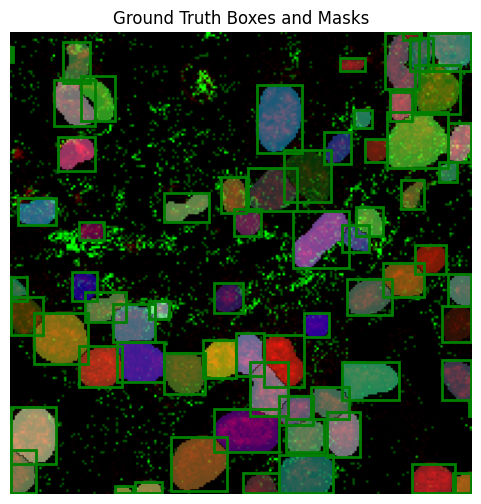

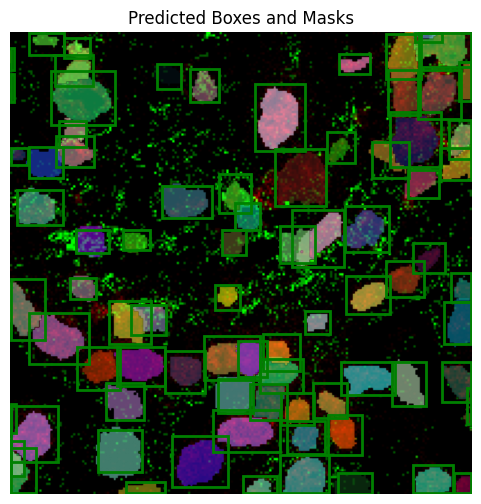

In [60]:
# Plot Ground Truth Masks
plt.figure(figsize=(6, 6))
plt.imshow(image)
for mask in gt_masks_transformed:
    show_mask(mask, plt.gca(), random_color=True, title="Ground Truth Boxes and Masks")
for box in original_boxes_gt:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

# Plot Predicted Masks
plt.figure(figsize=(6, 6))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True, title="Predicted Boxes and Masks")
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [61]:
import numpy as np
import torch
from scipy.optimize import linear_sum_assignment

def calculate_seg_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0
    return intersection / union

def calculate_dice(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    return 2 * intersection / (mask1.sum() + mask2.sum())

def evaluate_segmentation(gt_masks, pred_masks, iou_threshold=0.5):
    # Get unique masks from ground truth
    unique_vals = np.unique(gt_masks)
    unique_vals = unique_vals[unique_vals != 0]  # Remove background value
    
    # Convert predicted masks to numpy arrays
    pred_masks_np = pred_masks.squeeze(1).detach().cpu().numpy()
    
    num_gt = len(unique_vals)
    num_pred = pred_masks_np.shape[0]
    
    iou_matrix = np.zeros((num_gt, num_pred))
    
    for i, val in enumerate(unique_vals):
        gt_mask = gt_masks == val
        for j in range(num_pred):
            pred_mask = pred_masks_np[j]
            iou_matrix[i, j] = calculate_seg_iou(gt_mask, pred_mask)
    
    # Hungarian algorithm to find the best match
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)
    
    matched_pairs = [(i, j) for i, j in zip(row_ind, col_ind) if iou_matrix[i, j] >= iou_threshold]
    
    tp = len(matched_pairs)
    fp = num_pred - tp
    fn = num_gt - tp
    
    ious = [iou_matrix[i, j] for i, j in matched_pairs]
    dices = [calculate_dice(gt_masks == unique_vals[i], pred_masks_np[j]) for i, j in matched_pairs]
    
    mean_iou = np.mean(ious) if tp > 0 else 0
    mean_dice = np.mean(dices) if tp > 0 else 0
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    eva_results = {
        'mean_iou': mean_iou,
        'mean_dice': mean_dice,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn
    }
    
    return eva_results

In [62]:
metrics = evaluate_segmentation(ground_truth_masks, masks)

print('Segmentation results:')
print(f"Mean IOU       : {metrics['mean_iou']:.2f}")
print(f"Mean Dice      : {metrics['mean_dice']:.2f}")

print(f"Precision      : {metrics['precision']:.2f}")
print(f"Recall         : {metrics['recall']:.2f}")
print(f"F1 score       : {metrics['f1_score']:.2f}")

print(f"True Positives : {metrics['true_positives']}")
print(f"False Positives: {metrics['false_positives']}")
print(f"False Negatives: {metrics['false_negatives']}")

Segmentation results:
Mean IOU       : 0.62
Mean Dice      : 0.77
Precision      : 0.56
Recall         : 0.65
F1 score       : 0.60
True Positives : 45
False Positives: 35
False Negatives: 24


# Test on organoid images

In [63]:
'''#image_path = '/home/icb/hanyi.zhang/organoids_images/1709910822.png'
#image_path = '/home/icb/hanyi.zhang/organoids_images/1709910835.png'
#image_path = '/home/icb/hanyi.zhang/organoids_images/Picture2.png'
#image_path = '/home/icb/hanyi.zhang/organoids_images/Picture3.png'
img_list = []
img_list.append('/home/icb/hanyi.zhang/organoids_images/1709910822.png')
img_list.append('/home/icb/hanyi.zhang/organoids_images/Picture2.png')

for image_path in img_list:
    file_idx = image_path.rsplit('.', 1)[0]

    image_embedding_path = image_path.replace('.png', '.npy')
    # Load the image file and convert it to a numpy array
    with Image.open(image_path) as image:
        image = image.convert('RGB')
        img_np = np.array(image)

    # Process the image to get its embedding
    img_embed = sam_image_encoder.set_image(img_np)
    np.save(image_embedding_path, img_embed.cpu().detach().numpy())

    original_size = image.size  # (width, height)
    original_size = (original_size[1], original_size[0])  # Convert to (height, width)
    original_size

    image_embedding = np.load(image_embedding_path)

    # Predict boxes and convert to original size
    predicted_boxes, confidence_scores = evaluate_single_example(model, image_embedding)
    original_boxes_pred = inverse_boxes(convert_boxes(predicted_boxes) * 1024, original_size)

    kept_indices = non_max_suppression(original_boxes_pred, confidence_scores, threshold=0.1)

    original_boxes_pred_filtered = original_boxes_pred[kept_indices]
    filtered_confidences = confidence_scores[kept_indices]

    image = cv2.imread(image_path)
    predictor.set_image(image)

    input_boxes = torch.tensor(original_boxes_pred_filtered).to(device)
    #input_boxes = torch.tensor(original_boxes_pred).to(device) # Avoid NMS
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )

    # print number of boxes
    print('Number of predicted bboxes: ', str(len(input_boxes)))

    # plot bboxes with confidence scores
    title = image_path
    plot_bbox_with_confidence_score(image, original_boxes_pred_filtered, filtered_confidences, title, bbox_color='r', show_confidence_score=True)

    # Plot Predicted Masks
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask.cpu().numpy(), plt.gca(), random_color=True, title="Predicted Boxes and Masks\nNumber of bboxes: " + str(len(input_boxes)))
    for box in input_boxes:
        show_box(box.cpu().numpy(), plt.gca())
    plt.axis('off')
    plt.show()'''

'#image_path = \'/home/icb/hanyi.zhang/organoids_images/1709910822.png\'\n#image_path = \'/home/icb/hanyi.zhang/organoids_images/1709910835.png\'\n#image_path = \'/home/icb/hanyi.zhang/organoids_images/Picture2.png\'\n#image_path = \'/home/icb/hanyi.zhang/organoids_images/Picture3.png\'\nimg_list = []\nimg_list.append(\'/home/icb/hanyi.zhang/organoids_images/1709910822.png\')\nimg_list.append(\'/home/icb/hanyi.zhang/organoids_images/Picture2.png\')\n\nfor image_path in img_list:\n    file_idx = image_path.rsplit(\'.\', 1)[0]\n\n    image_embedding_path = image_path.replace(\'.png\', \'.npy\')\n    # Load the image file and convert it to a numpy array\n    with Image.open(image_path) as image:\n        image = image.convert(\'RGB\')\n        img_np = np.array(image)\n\n    # Process the image to get its embedding\n    img_embed = sam_image_encoder.set_image(img_np)\n    np.save(image_embedding_path, img_embed.cpu().detach().numpy())\n\n    original_size = image.size  # (width, height)\n

# Test on Dev 84

In [64]:
'''import cv2
# Define paths
img_folder = '/home/icb/hanyi.zhang/dev284_results_without_scores'
sub_folders = os.listdir(img_folder)
for sub_f in sub_folders:
    img_list = os.listdir(os.path.join(img_folder, sub_f))
    for img_name in img_list:
        img_path = os.path.join(img_folder, sub_f, img_name)

        # Load the image file and convert it to a numpy array
        with Image.open(img_path) as image:
            image = image.convert('RGB')
            img_np = np.array(image)

        # Process the image to get its embedding
        img_embed = sam_image_encoder.set_image(img_np)

        original_size = image.size  # (width, height)
        original_size = (original_size[1], original_size[0])  # Convert to (height, width)
        original_size

        # Predict boxes and convert to original size
        predicted_boxes, confidence_scores = evaluate_single_example(model, img_embed)
        original_boxes_pred = inverse_boxes(convert_boxes(predicted_boxes) * 1024, original_size)

        kept_indices = non_max_suppression(original_boxes_pred, confidence_scores, threshold=0.1)

        original_boxes_pred_filtered = original_boxes_pred[kept_indices]
        filtered_confidences = confidence_scores[kept_indices]

        image = cv2.imread(img_path)
        predictor.set_image(image)

        input_boxes = torch.tensor(original_boxes_pred_filtered).to(device)
        #input_boxes = torch.tensor(original_boxes_pred).to(device) # Avoid NMS
        transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
        masks, _, _ = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )

        # print number of boxes
        print('Number of predicted bboxes: ', str(len(input_boxes)))

        # plot bboxes with confidence scores
        title = 'dev284/' + sub_f + '/' + img_name
        save_path = img_path.replace('.png', '_bbox_only.png')
        plot_bbox_with_confidence_score(image, original_boxes_pred_filtered, filtered_confidences, title, bbox_color='r', show_confidence_score=False, save_path=save_path)

        # Plot Predicted Masks
        #plt.figure(figsize=(10, 10))
        plt.figure()
        plt.imshow(image)
        for mask in masks:
            show_mask(mask.cpu().numpy(), plt.gca(), random_color=True, title="Predicted Boxes and Masks\nNumber of bboxes: " + str(len(input_boxes)))
        for box in input_boxes:
            show_box(box.cpu().numpy(), plt.gca())
        plt.axis('off')
        plt.savefig(img_path.replace('.png', '_mask.png'))
        plt.show()'''

'import cv2\n# Define paths\nimg_folder = \'/home/icb/hanyi.zhang/dev284_results_without_scores\'\nsub_folders = os.listdir(img_folder)\nfor sub_f in sub_folders:\n    img_list = os.listdir(os.path.join(img_folder, sub_f))\n    for img_name in img_list:\n        img_path = os.path.join(img_folder, sub_f, img_name)\n\n        # Load the image file and convert it to a numpy array\n        with Image.open(img_path) as image:\n            image = image.convert(\'RGB\')\n            img_np = np.array(image)\n\n        # Process the image to get its embedding\n        img_embed = sam_image_encoder.set_image(img_np)\n\n        original_size = image.size  # (width, height)\n        original_size = (original_size[1], original_size[0])  # Convert to (height, width)\n        original_size\n\n        # Predict boxes and convert to original size\n        predicted_boxes, confidence_scores = evaluate_single_example(model, img_embed)\n        original_boxes_pred = inverse_boxes(convert_boxes(predicte

# Check distribution

In [65]:
'''import matplotlib.pyplot as plt

# Define the file path
file_path = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png-small/train/number_of_boxes.txt'

# Read the file and extract the numbers
numbers = []
with open(file_path, 'r') as file:
    for line in file:
        # Split the line by ': ' and take the second part, then convert it to an integer
        number = int(line.split(': ')[1])
        numbers.append(number)

# Plot the distribution of the numbers with specified x-axis intervals
bins = [10 * i for i in range(11)]  # Create bins from 0 to 100 with a step of 10

plt.hist(numbers, bins=bins, edgecolor='black', align='mid')
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Dataset with smaller patches (<100 objects)\nDistribution of Numbers')
plt.xticks(bins)  # Set x-axis ticks to match the bin edges
plt.show()
'''

"import matplotlib.pyplot as plt\n\n# Define the file path\nfile_path = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png-small/train/number_of_boxes.txt'\n\n# Read the file and extract the numbers\nnumbers = []\nwith open(file_path, 'r') as file:\n    for line in file:\n        # Split the line by ': ' and take the second part, then convert it to an integer\n        number = int(line.split(': ')[1])\n        numbers.append(number)\n\n# Plot the distribution of the numbers with specified x-axis intervals\nbins = [10 * i for i in range(11)]  # Create bins from 0 to 100 with a step of 10\n\nplt.hist(numbers, bins=bins, edgecolor='black', align='mid')\nplt.xlabel('Number')\nplt.ylabel('Frequency')\nplt.title('Dataset with smaller patches (<100 objects)\nDistribution of Numbers')\nplt.xticks(bins)  # Set x-axis ticks to match the bin edges\nplt.show()\n"

In [66]:
'''import matplotlib.pyplot as plt

# Define the file path
file_path = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png-small/train/number_of_boxes.txt'

# Read the file and extract the numbers
numbers = []
with open(file_path, 'r') as file:
    for line in file:
        # Split the line by ': ' and take the second part, then convert it to an integer
        number = int(line.split(': ')[1])
        numbers.append(number)

# Define the bins
bins = [10 * i for i in range(11)]  # Create bins from 0 to 100 with a step of 10

# Categorize the numbers into bins
categories = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
bin_counts = [0] * (len(bins)-1)

for number in numbers:
    for i in range(len(bins)-1):
        if bins[i] <= number < bins[i+1]:
            bin_counts[i] += 1
            break

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(bin_counts, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Dataset with smaller patches (<100 objects)\nDistribution of Numbers by Bins')
plt.show()
'''

"import matplotlib.pyplot as plt\n\n# Define the file path\nfile_path = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png-small/train/number_of_boxes.txt'\n\n# Read the file and extract the numbers\nnumbers = []\nwith open(file_path, 'r') as file:\n    for line in file:\n        # Split the line by ': ' and take the second part, then convert it to an integer\n        number = int(line.split(': ')[1])\n        numbers.append(number)\n\n# Define the bins\nbins = [10 * i for i in range(11)]  # Create bins from 0 to 100 with a step of 10\n\n# Categorize the numbers into bins\ncategories = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]\nbin_counts = [0] * (len(bins)-1)\n\nfor number in numbers:\n    for i in range(len(bins)-1):\n        if bins[i] <= number < bins[i+1]:\n            bin_counts[i] += 1\n            break\n\n# Plot the pie chart\nplt.figure(figsize=(8, 8))\nplt.pie(bin_counts, labels=categories, autopct='%1.1f%%', startangle=140)\nplt.title('Dataset with smaller patches (<

In [67]:
'''import matplotlib.pyplot as plt
import pandas as pd

# Define the file path
file_path = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/train/n_objects.csv'

# Read the CSV file
data = pd.read_csv(file_path)

# Extract the number of objects
numbers = data['Number of Objects']

# Plot the distribution of the numbers with specified x-axis intervals
bins = [i for i in range(0, 310, 10)]  # Create bins from 0 to 300 with a step of 10

plt.figure(figsize=(16, 8))  # Make the plot larger
plt.hist(numbers, bins=bins, edgecolor='black', align='mid')
plt.xlabel('Number of Objects')
plt.ylabel('Frequency')
plt.title('Dataset with larger patches (<300 objects)\nDistribution of Numbers')
plt.xticks(bins)  # Set x-axis ticks to match the bin edges

# Add labels on top of each bar
counts, bin_edges, _ = plt.hist(numbers, bins=bins, edgecolor='black', align='mid')
for count, bin_edge in zip(counts, bin_edges[:-1]):
    plt.text(bin_edge + 5, count, str(int(count)), ha='center', va='bottom')

plt.show()
'''

"import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Define the file path\nfile_path = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/train/n_objects.csv'\n\n# Read the CSV file\ndata = pd.read_csv(file_path)\n\n# Extract the number of objects\nnumbers = data['Number of Objects']\n\n# Plot the distribution of the numbers with specified x-axis intervals\nbins = [i for i in range(0, 310, 10)]  # Create bins from 0 to 300 with a step of 10\n\nplt.figure(figsize=(16, 8))  # Make the plot larger\nplt.hist(numbers, bins=bins, edgecolor='black', align='mid')\nplt.xlabel('Number of Objects')\nplt.ylabel('Frequency')\nplt.title('Dataset with larger patches (<300 objects)\nDistribution of Numbers')\nplt.xticks(bins)  # Set x-axis ticks to match the bin edges\n\n# Add labels on top of each bar\ncounts, bin_edges, _ = plt.hist(numbers, bins=bins, edgecolor='black', align='mid')\nfor count, bin_edge in zip(counts, bin_edges[:-1]):\n    plt.text(bin_edge + 5, count, str(int(count)), ha='center',

In [68]:
'''import matplotlib.pyplot as plt
import pandas as pd

# Define the file path
file_path = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/train/n_objects.csv'

# Read the CSV file
data = pd.read_csv(file_path)

# Extract the number of objects
numbers = data['Number of Objects']

# Define the bins
bins = [i for i in range(0, 310, 10)]  # Create bins from 0 to 300 with a step of 10

# Categorize the numbers into bins
categories = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
bin_counts = pd.cut(numbers, bins=bins, labels=categories).value_counts().sort_index()

# Plot the pie chart
plt.figure(figsize=(10, 10))
plt.pie(bin_counts, labels=bin_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Dataset with larger patches (<300 objects)\nDistribution of Numbers by Bins')
plt.show()
'''

"import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Define the file path\nfile_path = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/train/n_objects.csv'\n\n# Read the CSV file\ndata = pd.read_csv(file_path)\n\n# Extract the number of objects\nnumbers = data['Number of Objects']\n\n# Define the bins\nbins = [i for i in range(0, 310, 10)]  # Create bins from 0 to 300 with a step of 10\n\n# Categorize the numbers into bins\ncategories = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]\nbin_counts = pd.cut(numbers, bins=bins, labels=categories).value_counts().sort_index()\n\n# Plot the pie chart\nplt.figure(figsize=(10, 10))\nplt.pie(bin_counts, labels=bin_counts.index, autopct='%1.1f%%', startangle=140)\nplt.title('Dataset with larger patches (<300 objects)\nDistribution of Numbers by Bins')\nplt.show()\n"